In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from joblib import dump

In [2]:
B_SIZE = 256
img_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CelebA_Dataset(Dataset):
    def __init__(self, data_dir, split, transform):
        super().__init__()
        self.img_dir = os.path.join(data_dir + "/img_align_celeba")
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.make_split()
    
    def make_split(self):
        partition_list_path = os.path.join(self.data_dir, "list_eval_partition.txt")
        partition_list = np.loadtxt(partition_list_path, dtype=str)
        if self.split == "train":
            self.img_names = partition_list[partition_list[:, 1].astype(float) == 0, 0]
        elif self.split == "test":
            self.img_names = partition_list[partition_list[:, 1].astype(float) > 0, 0]
            
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.img_names)
    
    def t(self, img):
        return self.transform(img)
        
    def __getitem__(self, idx):
        file_name = os.path.join(self.img_dir, self.img_names[idx])
        img = np.array(Image.open(file_name))
        
        if self.transform:
            img = self.t(img)
    
        return img

In [4]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((img_size, img_size)),
#                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((img_size, img_size)),
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

In [5]:
train_dataset = CelebA_Dataset("./data", "train", t)
test_dataset = CelebA_Dataset("./data", "test", test_transform)

In [6]:
def visual(img_to_display=4):
    print("Displaying images in the dataset")
    fig, ax = plt.subplots(1, img_to_display)
    fig.set_size_inches(25, 8)
    
    for id in range(img_to_display):
        ax[id].imshow(test_dataset[id].permute(1,2,0))
        ax[id].axis("off")
    plt.tight_layout()
    plt.show()

In [7]:
# visual()

In [8]:
train_loader = DataLoader(train_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=B_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [63]:
"""
Reference: https://github.com/AntixK/PyTorch-VAE/blob/master/models/cvae.py
with modificaiton
"""

class ConvVAE(nn.Module):

    def __init__(self, in_channels=3, out_channels=[32, 64, 128, 256, 512], latent_dim=128, fc_dim=512*4*4):
        """ Model initlaizer """

        super().__init__()

        self.out_channels = out_channels
        self.fc_dim = fc_dim
        self.latent_dim = latent_dim
        self.img_channel = in_channels
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_sigma = nn.Linear(fc_dim, latent_dim)

        return

 
    def _make_encoder(self):
        layers = []
        in_channels = self.img_channel
        for h_dim in self.out_channels:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        encoder = nn.Sequential(*layers)

        return encoder

    def _make_decoder(self):

        modules = []

        self.decoder_input = nn.Linear(self.latent_dim, self.fc_dim)

        self.out_channels.reverse()

        for i in range(len(self.out_channels) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(self.out_channels[i],
                                       self.out_channels[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(self.out_channels[i + 1]),
                    nn.LeakyReLU())
            )

        decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(self.out_channels[-1],
                               self.out_channels[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(self.out_channels[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(self.out_channels[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Tanh())
        return decoder

    def encode(self,x):
        out = self.encoder(x)
        out = torch.flatten(out, 1)
        mu = self.fc_mu(out)
        log_var = self.fc_sigma(out)

        return mu, log_var
    
    def decode(self,z):
        z_in = self.decoder_input(z)
        z_in = z_in.view(-1, 512, 4, 4)
        x_hat = self.decoder(z_in)
        x_hat = self.final_layer(x_hat)

        return x_hat
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) 
        return mu + std * eps
        

    def forward(self, x):
        
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)

        return x_hat, mu, log_var

In [11]:
def train(model, train_loader, optimizer, epoch):
    """
    Training for one epoch
    """
    loss_list = []
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, images in pbar:
       
        # put on gpu
        images = images.to(device)
        model = model.to(device)
        
        optimizer.zero_grad()
        
        img_recon, mu, logVar = model(images)

        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

        loss =  F.mse_loss(img_recon, images, reduction="sum") + kl_divergence

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        running_loss =+ loss.item()
        
        if idx % 1 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

    avg_loss = np.mean(loss_list)

    return loss_list, avg_loss

@torch.no_grad()
def testing(model, test_loader):
    """
    Testing the accuracy for validation set
    """
    model.eval()
    correct = 0
    loss_list = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))

    for idx, images in pbar:
        images = images.to(device)
        model = model.to(device)
        
        img_recon, mu, logVar = model(images)

        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

        loss = F.mse_loss(img_recon, images, reduction="sum") + kl_divergence
        
        loss_list.append(loss.item())

    return np.mean(loss_list)
        
def training_model(model, optimizer, scheduler, train_loader, valid_loader, num_epochs):
    """
    Training and testing of model for N number of EPOCHS
    """
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "loss_iters":[]
    }
    for epoch in range(num_epochs):
        # testing 
        v_loss = testing(model, valid_loader)
        stats["val_loss"].append(v_loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        
        epoch_loss_list, epoch_loss = train(model, train_loader, optimizer, epoch)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
            
        saving_model(model, optimizer, epoch, stats)
        print(f"Loss for epoch: {epoch+1} is: ", stats["val_loss"][-1])

    print(f"Training completed")

In [12]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/ConvVAE_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

In [13]:
def training_full_model(model, train_loader, valid_loader, num_epochs):
    LR = 3e-4
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training_model(model, optimizer, scheduler, train_loader, valid_loader, num_epochs)

In [14]:
convVae = ConvVAE()

In [15]:
training_full_model(convVae, train_loader, test_loader, 30)

Epoch 1, Itr 636, Loss 166657.64062: 100%|████| 636/636 [03:52<00:00,  2.74it/s]


Loss for epoch: 1 is:  3381493.0713141025


Epoch 2, Itr 636, Loss 143382.35938: 100%|████| 636/636 [03:55<00:00,  2.70it/s]


Loss for epoch: 2 is:  202003.25265424678


Epoch 3, Itr 636, Loss 137756.34375: 100%|████| 636/636 [03:49<00:00,  2.77it/s]


Loss for epoch: 3 is:  175994.29166666666


Epoch 4, Itr 636, Loss 134593.65625: 100%|████| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 4 is:  169230.19100560897


Epoch 5, Itr 636, Loss 131938.93750: 100%|████| 636/636 [03:48<00:00,  2.78it/s]


Loss for epoch: 5 is:  161305.1252003205


Epoch 6, Itr 636, Loss 125186.30469: 100%|████| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 6 is:  158009.87570112178


Epoch 7, Itr 636, Loss 126373.73438: 100%|████| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 7 is:  155910.56169871794



Epoch 8, Itr 636, Loss 124870.87500: 100%|████| 636/636 [03:48<00:00,  2.78it/s]

Loss for epoch: 8 is:  152643.93434495194



Epoch 9, Itr 636, Loss 121917.95312: 100%|████| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 9 is:  148147.75701121794


Epoch 10, Itr 636, Loss 125323.10156: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 10 is:  147951.79442107372



Epoch 11, Itr 636, Loss 123123.76562: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 11 is:  147715.58248197116



Epoch 12, Itr 636, Loss 118625.69531: 100%|███| 636/636 [03:47<00:00,  2.79it/s]


Loss for epoch: 12 is:  147663.5179286859


Epoch 13, Itr 636, Loss 120269.36719: 100%|███| 636/636 [03:47<00:00,  2.79it/s]

Loss for epoch: 13 is:  146868.47686298078



Epoch 14, Itr 636, Loss 121102.78125: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 14 is:  146150.23307291666



Epoch 15, Itr 636, Loss 120943.32812: 100%|███| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 15 is:  145920.9520733173


Epoch 16, Itr 636, Loss 120605.46875: 100%|███| 636/636 [03:47<00:00,  2.79it/s]

Loss for epoch: 16 is:  145193.6294571314



Epoch 17, Itr 636, Loss 116522.45312: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 17 is:  145126.8895733173



Epoch 18, Itr 636, Loss 120748.34375: 100%|███| 636/636 [03:47<00:00,  2.79it/s]


Loss for epoch: 18 is:  145053.3446514423


Epoch 19, Itr 636, Loss 120360.32031: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 19 is:  145017.17693309294



Epoch 20, Itr 636, Loss 115923.43750: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 20 is:  144950.15454727566



Epoch 21, Itr 636, Loss 116728.35938: 100%|███| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 21 is:  145004.92237580128


Epoch 22, Itr 636, Loss 117476.85156: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 22 is:  144850.80724158653



Epoch 23, Itr 636, Loss 119066.86719: 100%|███| 636/636 [03:48<00:00,  2.78it/s]

Loss for epoch: 23 is:  144844.0967548077



Epoch 24, Itr 636, Loss 121279.44531: 100%|███| 636/636 [03:48<00:00,  2.79it/s]


Loss for epoch: 24 is:  144880.80809294872


Epoch 25, Itr 636, Loss 122537.28125: 100%|███| 636/636 [03:48<00:00,  2.79it/s]

Loss for epoch: 25 is:  144872.96955128206



Epoch 26, Itr 636, Loss 117642.44531: 100%|███| 636/636 [03:47<00:00,  2.79it/s]

Loss for epoch: 26 is:  144849.51677684294



Epoch 27, Itr 636, Loss 117761.91406: 100%|███| 636/636 [03:48<00:00,  2.78it/s]


Loss for epoch: 27 is:  144794.01772836538


Epoch 28, Itr 636, Loss 116574.57031: 100%|███| 636/636 [03:46<00:00,  2.81it/s]

Loss for epoch: 28 is:  144787.39908854166



Epoch 29, Itr 636, Loss 115418.67188: 100%|███| 636/636 [03:46<00:00,  2.80it/s]

Loss for epoch: 29 is:  144791.1837940705



Epoch 30, Itr 636, Loss 117518.43750: 100%|███| 636/636 [03:46<00:00,  2.81it/s]


Loss for epoch: 30 is:  144733.63131009616
Training completed


In [44]:
def img_regeneration(model):
    with torch.no_grad():
        num_preds = 16
        test_z = torch.normal(0, 1, size=(1, 128)).to(device)
        out = conv_model.decode(test_z)
        out = out[0].permute(1,2,0)
    return out

In [45]:
conv_model, optimizer, epoch, stats = loading_model(convVae, "models/ConvVAE_30.pth")

In [46]:
out = img_regeneration(conv_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


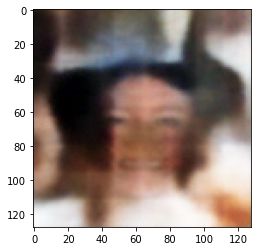

In [47]:
plt.imshow(out.to("cpu"))

## Training-Validation Plots

So now is the time to see how the plots look like. As one can see validation loss started larger tham training loss since we are testing first and then training, but the loss plumted and after 10 epochs it was already much lower than when it started. 

After 16 epochs the loss never really changed. But if we observe closly we see that the training loss was much larger than the validation loss

Text(0.5, 1.0, '')

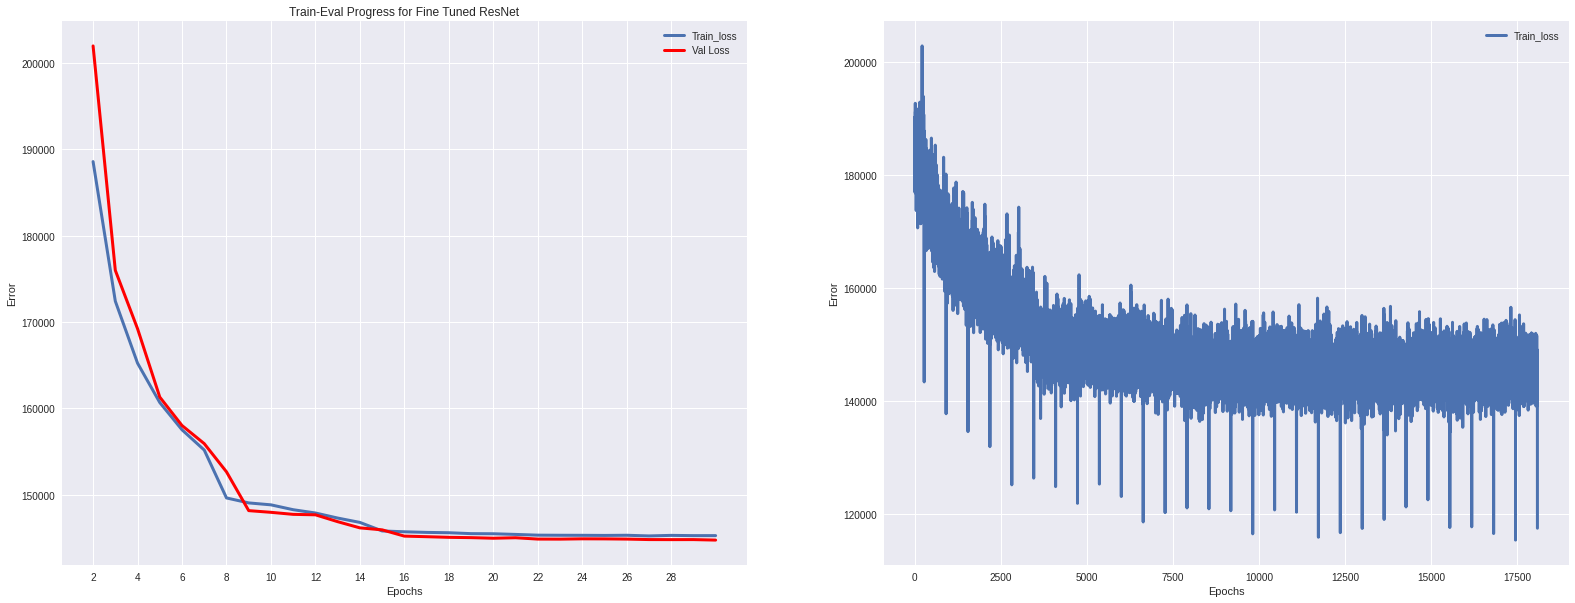

In [62]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(27, 10)

ax[0].plot(stats['epoch'][1:], stats['train_loss'][1:], label="Train_loss", linewidth=3)
ax[0].plot(stats['epoch'][1:], stats['val_loss'][1:], label="Val Loss", c='red', linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 29, step=2))

ax[0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[1].plot(stats['loss_iters'][1000:], label="Train_loss", linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
# ax[1].set_xticks(np.arange(2, 29, step=2))

ax[1].set_title("")

In [58]:
stats.keys()

dict_keys(['epoch', 'train_loss', 'val_loss', 'loss_iters'])

In [ ]:
# add filter 
# add recons 